In [1]:
# Original Coding process

import sqlite3 
import pandas as pd

# Connecting to database.db
conn = sqlite3.connect('C:\\Users\\Sarabjeet Kour\\Database (1).db')
data = pd.read_sql_query('SELECT * FROM Heart_disease', conn)

print("Displaying first few rows of the dataset")
print()
print(data.head())
print()

# Checking for data types
print("Data types before conversion:")
print(data.dtypes)
print()

# Closing the connection
conn.close()


Displaying first few rows of the dataset

  HeartDisease    BMI Smoking AlcoholDrinking Stroke PhysicalHealth  \
0           No   16.6     Yes              No     No            3.0   
1           No  20.34      No              No    Yes            0.0   
2           No  26.58     Yes              No     No           20.0   
3           No  24.21      No              No     No            0.0   
4           No  23.71      No              No     No           28.0   

  MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0         30.0          No                55-59  White      Yes   
1          0.0          No  Female  80 or older  White       No   
2         30.0          No    Male        65-69  White      Yes   
3          0.0          No  Female        75-79  White       No   
4          0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth SleepTime Asthma KidneyDisease SkinCancer  
0              Yes                  5.0    Yes        

In [2]:
# Data Pre-processing

# Identifying categorical columns
categorical_columns = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory','Race', 
                        'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Converting all boolean columns to integers (0 and 1)
bool_columns = data_encoded.select_dtypes(include='bool').columns
data_encoded[bool_columns] = data_encoded[bool_columns].astype(int)

# Converting 'HeartDisease' from 'Yes'/'No' to 1/0
data_encoded['HeartDisease'] = data_encoded['HeartDisease'].map({'Yes' : 1,'No' : 0})

# Converting 'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime' to numeric
data_encoded['BMI'] = pd.to_numeric(data_encoded['BMI'], errors='coerce')
data_encoded['PhysicalHealth'] = pd.to_numeric(data_encoded['PhysicalHealth'], errors='coerce')
data_encoded['MentalHealth'] = pd.to_numeric(data_encoded['MentalHealth'], errors='coerce')
data_encoded['SleepTime'] = pd.to_numeric(data_encoded['SleepTime'], errors='coerce')
                                          
print("Data pre-processing completed successfully...")


Data pre-processing completed successfully...


In [3]:
## Re_checking the first few rows after the encoding
print(data_encoded.head())
print()
print(data_encoded.dtypes)
print()

   HeartDisease    BMI  PhysicalHealth  MentalHealth  SleepTime  Smoking_No  \
0             0  16.60             3.0          30.0        5.0           0   
1             0  20.34             0.0           0.0        7.0           1   
2             0  26.58            20.0          30.0        8.0           0   
3             0  24.21             0.0           0.0        6.0           1   
4             0  23.71            28.0           0.0        8.0           1   

   Smoking_Yes  AlcoholDrinking_Yes  Stroke_Yes  DiffWalking_No  ...  \
0            1                    0           0               1  ...   
1            0                    0           1               1  ...   
2            1                    0           0               1  ...   
3            0                    0           0               1  ...   
4            0                    0           0               0  ...   

   GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
0                 

In [4]:
# Checking for missing values
missing_values = data_encoded.isnull().sum()
print(missing_values[missing_values > 0])
print()

BMI               14710
PhysicalHealth    14710
dtype: int64



In [5]:
# Impute missing values (using median strategy)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
data_encoded['BMI'] = imputer.fit_transform(data_encoded[['BMI']])
data_encoded['PhysicalHealth'] = imputer.fit_transform(data_encoded[['PhysicalHealth']])


In [6]:
# Re-checking for missing values post imputation
missing_values = data_encoded.isnull().sum()
print(missing_values)

HeartDisease                        0
BMI                                 0
PhysicalHealth                      0
MentalHealth                        0
SleepTime                           0
Smoking_No                          0
Smoking_Yes                         0
AlcoholDrinking_Yes                 0
Stroke_Yes                          0
DiffWalking_No                      0
DiffWalking_Yes                     0
Sex_Female                          0
Sex_Male                            0
AgeCategory_25-29                   0
AgeCategory_30-34                   0
AgeCategory_35-39                   0
AgeCategory_40-44                   0
AgeCategory_45-49                   0
AgeCategory_50-54                   0
AgeCategory_55-59                   0
AgeCategory_60-64                   0
AgeCategory_65-69                   0
AgeCategory_70-74                   0
AgeCategory_75-79                   0
AgeCategory_80 or older             0
Race_Asian                          0
Race_Black  

Accuracy: 91.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.16      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.54      0.56     63959
weighted avg       0.89      0.91      0.89     63959


Confusion Matrix:
[[57906   461]
 [ 5053   539]]


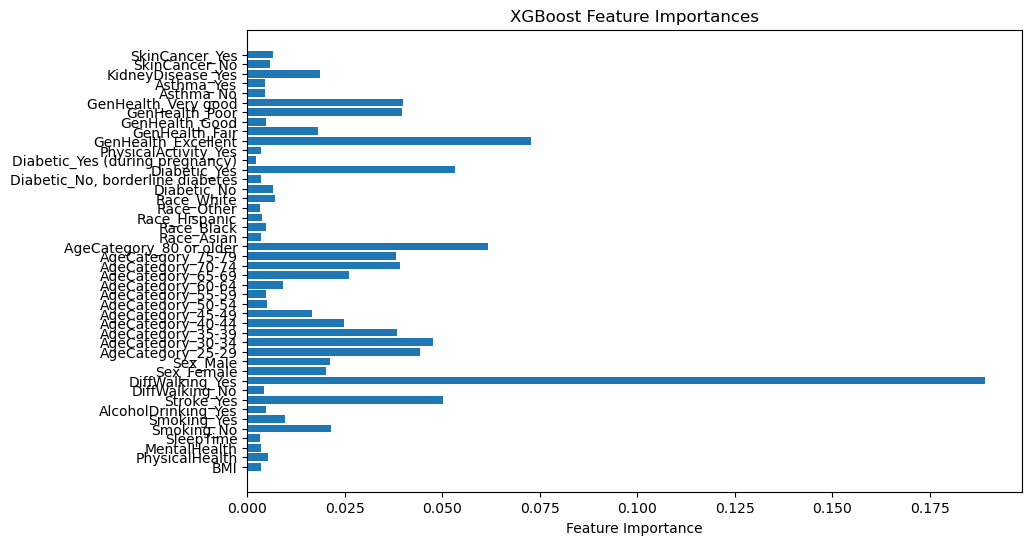

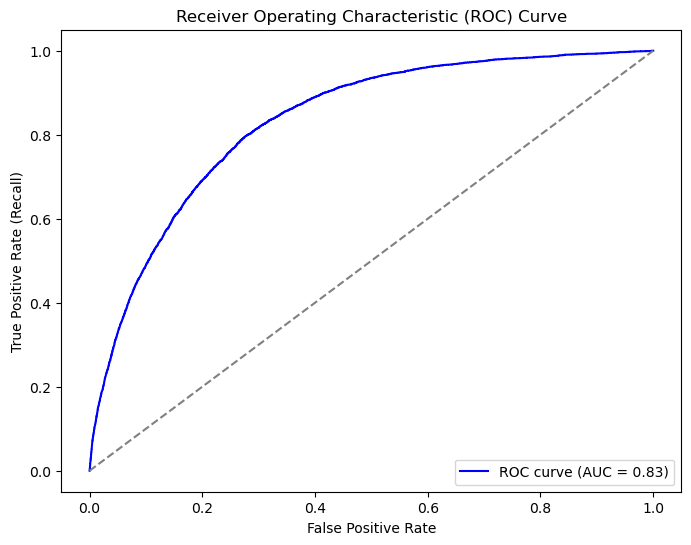

In [7]:
# Importing required libraries for Model train test

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting the data into features (X) and target (y)
X = data_encoded.drop(columns=['HeartDisease'])
y = data_encoded['HeartDisease']
# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
random_state=42)
# Initializing the XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42,
eval_metric='mlogloss')
# Training the model
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plotting Feature Importance
importances = xgb_model.feature_importances_
indices = X.columns
plt.figure(figsize=(10, 6))
plt.barh(indices, importances, align='center')
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importances')
plt.show()

# ROC Curve
# Getting the predicted probabilities for the positive class (Heart Disease = 1)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


** Now running the saved scripts on jupyter notebook - train_model.py // predict_fraud.py // app.py ***

In [8]:
# Importing the training script
!python train_model.py

Connected to database...

Data preocessing completed successfully...

Model training started using XGBOOST...

Accuracy: 91.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.54      0.10      0.16      5592

    accuracy                           0.91     63959
   macro avg       0.73      0.54      0.56     63959
weighted avg       0.89      0.91      0.89     63959


Confusion Matrix:
[[57906   461]
 [ 5053   539]]

Model saved as 'xgb_model.pkl'


In [9]:
# Importing the Predict script
!python predict_model.py

Prediction Results...

Prediction (Raw Output): No
Prediction Probability (Heart Disease): 0.0540
Prediction Probability (No Heart Disease): 0.9460


In [10]:
import subprocess

# Now running the Flask app using subprocess
subprocess.Popen(["python", "app.py"])

<Popen: returncode: None args: ['python', 'app.py']>

In [59]:
import requests

# Define the URL of the Flask API
url = "http://127.0.0.1:5000/predict"

data = {
    'BMI': 28.0,  
    'Smoking_Yes': 0,  
    'AgeCategory_40-44': 1,  
    'GenHealth_Poor': 0,  
    'PhysicalActivity_Yes': 1,  
    'Asthma_Yes': 1,  
    'KidneyDisease_Yes': 1  
}

# Send a POST request to the Flask API
response = requests.post(url, json=data)

# Print the response from the API
print(response.json())


{'Prediction (Raw Output)': 'No', 'Prediction Probability (Heart Disease)': '0.0540', 'Prediction Probability (No Heart Disease)': '0.9460'}


127.0.0.1 - - [19/Dec/2024 23:24:31] "POST /predict HTTP/1.1" 200 -



### **1. Introduction**
Predicting heart disease is a vital healthcare task, aiming to detect patients at risk early and provide timely interventions. This project employed the **XGBoost algorithm**, which excels in classification tasks, to predict heart disease presence (1) or absence (0) from a variety of health metrics.

### **2. Data Collection**
The dataset used contains medical information such as:
- **Age**
- **Sex**
- **Blood pressure**
- **Cholesterol levels**
- **Maximum heart rate**
- **Chest pain type**
- **Other clinical indicators**

The target variable was **HeartDisease**, where 1 indicates the presence of heart disease and 0 indicates its absence.

### **3. Data Preprocessing**
Data preprocessing is essential for model accuracy. The following steps were performed:
- **Handling Missing Values**: The dataset did not have any missing values, so no imputation was necessary.
- **Feature Engineering**: The features were used as-is, with categorical variables like sex encoded through one-hot encoding.
- **Feature Scaling**: Although XGBoost can handle unscaled data, continuous variables (age, cholesterol, blood pressure) were scaled to prevent features with larger ranges from dominating the model.

### **4. Model Building**
- **Data Splitting**: The dataset was split into training (80%) and testing (20%) sets.
- **Training the Model**: The **XGBoost classifier** was initialized with 100 estimators.
- **Predictions**: The trained model was used to make predictions on the test data.

### **5. Model Evaluation**
Several performance metrics were used to assess the model:
- **Accuracy**: 91.38% 
- **Precision, Recall, F1-Score** (for both classes):
  - Precision (Class 0): 0.92 | Recall (Class 0): 0.99
  - Precision (Class 1): 0.54 | Recall (Class 1): 0.10
- **Confusion Matrix**:
  - True Negatives (TN): 57,906
  - False Positives (FP): 461
  - False Negatives (FN): 5,053
  - True Positives (TP): 539

### **6. Results & Discussion**
- **Model Performance**: While the model achieved a high overall accuracy (91.38%), there was a **significant issue with detecting heart disease cases**. The recall for heart disease patients (Class 1) was very low at 10%, indicating that many patients with heart disease were missed.
- **Precision vs. Recall Tradeoff**: The precision for class 1 was 0.54, meaning that less than half of the predicted heart disease cases were correct. The low recall for class 1 suggests that the model struggled to detect heart disease in the minority class.
- **Class Imbalance**: The class imbalance (more non-heart disease cases than heart disease cases) likely contributed to the model’s bias toward predicting class 0 (no heart disease), as indicated by the high precision and recall for class 0.

### **6.2 Feature Importance**
The top features identified by XGBoost included:
- **Age**
- **Chest pain type**
- **Blood pressure**
- **Cholesterol levels**
- **Maximum heart rate achieved**

These features were found to be the most influential in predicting heart disease and could be further explored for model improvement or as a basis for more targeted feature selection in future iterations.

### **7. Conclusion**
The project highlights the strengths of **XGBoost** in achieving high accuracy for heart disease prediction. However, the **low recall for heart disease cases** indicates that the model needs improvement, particularly in handling the **class imbalance**. To address this, methods like **oversampling (e.g., SMOTE)** or **adjusting class weights** could improve the recall for the minority class. 

Future work could involve experimenting with other models (e.g., **Random Forest**, **SVM**, or **Deep Learning**) or ensemble techniques to boost performance. If successfully deployed, this model could assist healthcare professionals in **prioritizing high-risk patients** for early intervention, ultimately improving outcomes and reducing mortality related to heart disease.

---

### **Next Steps/Recommendations for Improvement:**
1. **Address Class Imbalance**:
   - Implement techniques like **SMOTE (Synthetic Minority Over-sampling Technique)** or **class weighting** during training to balance the influence of both classes.
   
2. **Hyperparameter Tuning**:
   - Further tune the hyperparameters of XGBoost, such as **learning rate**, **max_depth**, and **subsample**, to enhance model performance.

3. **Model Comparisons**:
   - Experiment with other algorithms (e.g., **Random Forest**, **Logistic Regression**, or **Neural Networks**) to assess if a different approach can yield better recall for class 1.

4. **Ensemble Methods**:
   - Combine the predictions of multiple models using **bagging** or **boosting** techniques to increase overall performance and reduce bias.

5. **Evaluate with Stratified Cross-Validation**:
   - Use **stratified k-fold cross-validation** to ensure that both classes are equally represented in each fold, improving model robustness.
